In [ ]:
import argparse
import os
import cv2
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset
import utils
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary
from torch.nn import functional as F
from torch.nn import Parameter
import trainer
from network_module import *

In [ ]:
!python train.py    --epochs 40
                    --lr_g 0.0001
                    --batch_size 4
                    --lambda_perceptual 100
                    --lambda_l1 300
                    --baseroot /dataset/
                    --mask_type 'free_form'
                    --imgsize 512

In [ ]:
parser = argparse.ArgumentParser()
# General parameters
parser.add_argument('--save_path', type = str, default = './models', help = 'saving path that is a folder')
parser.add_argument('--sample_path', type = str, default = './samples', help = 'training samples path that is a folder')
parser.add_argument('--gan_type', type = str, default = 'WGAN', help = 'the type of GAN for training')
parser.add_argument('--multi_gpu', type = bool, default = False, help = 'nn.Parallel needs or not')
parser.add_argument('--gpu_ids', type = str, default = "0", help = 'gpu ids: e.g. 0  0,1,2, 0,2. use -1 for CPU')
parser.add_argument('--cudnn_benchmark', type = bool, default = True, help = 'True for unchanged input data type')
parser.add_argument('--checkpoint_interval', type = int, default = 1, help = 'interval between model checkpoints')
parser.add_argument('--load_name_g', type = str, default = '', help = 'load model name')#./models/deepfillv2_WGAN_epoch2_batchsize4.pth
parser.add_argument('--load_name_d', type=str, default='', help='load model name')#./models/discriminator_WGAN_epoch2_batchsize4.pth
# Training parameters
parser.add_argument('--epochs', type = int, default = 40, help = 'number of epochs of training')
parser.add_argument('--batch_size', type = int, default = 4, help = 'size of the batches')
parser.add_argument('--lr_g', type = float, default = 1e-4, help = 'Adam: learning rate')
parser.add_argument('--lr_d', type = float, default = 4e-4, help = 'Adam: learning rate')
parser.add_argument('--weight_decay', type = float, default = 0, help = 'Adam: weight decay')
parser.add_argument('--lr_decrease_epoch', type = int, default = 10, help = 'lr decrease at certain epoch and its multiple')
parser.add_argument('--lr_decrease_factor', type = float, default = 0.5, help = 'lr decrease factor, for classification default 0.1')
parser.add_argument('--lambda_l1', type = float, default = 256, help = 'the parameter of L1Loss')
parser.add_argument('--lambda_perceptual', type = float, default = 100, help = 'the parameter of FML1Loss (perceptual loss)')
parser.add_argument('--num_workers', type = int, default = 16, help = 'number of cpu threads to use during batch generation')
# Network parameters
parser.add_argument('--latent_channels', type = int, default = 32, help = 'latent channels')
parser.add_argument('--pad_type', type = str, default = 'replicate', help = 'the padding type')
parser.add_argument('--activation', type = str, default = 'elu', help = 'the activation type')
parser.add_argument('--norm1', type = str, default = 'none', help = 'normalization type')
parser.add_argument('--norm', type=str, default='none', help='normalization type')
parser.add_argument('--init_type', type = str, default = 'kaiming', help = 'the initialization type')
parser.add_argument('--init_gain', type = float, default = 0.2, help = 'the initialization gain')
# Dataset parameters
parser.add_argument('--baseroot', type = str, default = './dataset/data_large', help = 'the training folder: val_256, test_large, data_256')
parser.add_argument('--mask_type', type = str, default = 'free_form', help = 'mask type')
parser.add_argument('--imgsize', type = int, default = 512, help = 'size of image')
parser.add_argument('--margin', type = int, default = 10, help = 'margin of image')
parser.add_argument('--bbox_shape', type = int, default = 30, help = 'margin of image for bbox mask')
opt = parser.parse_args()
print(opt)

'''
# ----------------------------------------
#       Choose CUDA visible devices
# ----------------------------------------
if opt.multi_gpu == True:
    os.environ["CUDA_VISIBLE_DEVICES"] = opt.gpu_ids
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
'''

trainer.WGAN_trainer(opt)

# Init

In [ ]:
!nvidia-smi

Sun May 12 02:23:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    18W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils import data

# Data

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
dataset = torchvision.datasets.CelebA(root='./data', split='train', download=True, transform=transform)
test = torchvision.datasets.CelebA(root='./data', split='test', download=True, transform=transform)

0it [00:00, ?it/s]

100%|█████████▉| 170303488/170498071 [00:13<00:00, 17793544.35it/s]

Files already downloaded and verified


In [ ]:
train_split, val_split, test_split = 0.9, 0.05, 0.05
train_size = int(len(dataset) * train_split)
val_size = int(len(dataset) * val_split)
test_size = int(len(dataset) * test_split)

train, val, test = data.random_split(dataset, (train_size, val_size, test_size))
print(len(train), len(val), len(test))

45000 2500 2500


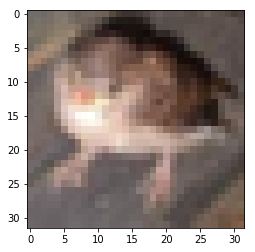

In [ ]:
def imshow(tensor):
    if len(tensor.shape) == 4:
        tensor = tensor[0]
    plt.imshow(tensor.cpu()[:3].permute(1, 2, 0))

imshow(train[1000][0])

# Masks

In [ ]:
def create_hole_mask(im_h, im_w, hole_h, hole_w):
    i = int((im_h - hole_h + 1) * np.random.random())
    j = int((im_w - hole_w + 1) * np.random.random())
    mask = torch.zeros((1, im_h, im_w))
    mask[0, i : i + hole_h, j : j + hole_w] = 1
    return mask, (i, i + hole_h, j, j + hole_w)

def create_hole_masks(N, im_h, im_w, hole_h, hole_w, same_size=True):
    if same_size:
        masks = [create_hole_mask(im_h, im_w, hole_h, hole_w) for _ in range(N)]
    else:
        h_min, h_max = hole_h
        w_min, w_max = hole_w
        hs, ws = np.random.randint(h_min, h_max, N), np.random.randint(w_min, w_max, N)
        masks = [create_hole_mask(im_h, im_w, h, w) for h, w in zip(hs, ws)]

    bounds = [mask[1] for mask in masks]
    masks = [mask[0] for mask in masks]
    masks = torch.cat(masks, dim=0)
    return masks.unsqueeze(1), bounds

In [ ]:
create_hole_masks(2, 3, 3, 1, 1)

(tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 1., 0.]]],
 
 
         [[[1., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]]]), [(2, 3, 1, 2), (0, 1, 0, 1)])

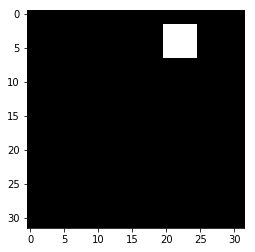

In [ ]:
plt.imshow(create_hole_mask(32, 32, 5, 5)[0][0], cmap='gray')

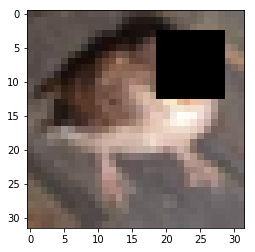

In [ ]:
imshow((1 - create_hole_mask(32, 32, 10, 10)[0][0]) * train[1000][0])

# GAN

## Generator

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

class Unflatten(nn.Module):
    
    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape
    
    def forward(self, X):
        return X.view(-1, *self.shape)

class Generator(nn.Module):
    
    def __init__(self, im_channels):
        super(Generator, self).__init__()
        
        
        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, 3, stride=1, padding=2, dilation=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=4, dilation=4),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=8, dilation=8),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=16, dilation=16),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, im_channels, 3, stride=1, padding=1)
            
        )

    def forward(self, X):
        out = self.net(X)
        return out
    
# g = Generator(2)
# g.eval()
# g(train[0][0].unsqueeze(0)).shape

## Local Discriminator

In [ ]:
class LocalDiscriminator(nn.Module):
    def __init__(self, im_channels, region_size=16):
        super(LocalDiscriminator, self).__init__()
        
        self.region_size = region_size
        
        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )
        
    def forward(self, X, mask_bounds):
        
        local_regions = self._get_local_regions(X, mask_bounds)
        out = self.net(local_regions)
        
        return out
    
    def _get_local_regions(self, X, mask_bounds):

        N, ch, im_h, im_w = X.shape
        local_regions = torch.zeros((N, ch, self.region_size, self.region_size)).cuda()

        for i, bounds in enumerate(mask_bounds):
            y1, y2, x1, x2 = bounds
            
            ym, xm = (y1 + y2) // 2, (x1 + x2) // 2
            y1, x1 = ym - self.region_size // 2, xm - self.region_size // 2
            y2, x2 = y1 + self.region_size, x1 + self.region_size
            
            if y1 < 0:
                y1, y2 = 0, self.region_size
            elif y2 > im_h:
                y1, y2 = im_h - self.region_size, im_h
                
            if x1 < 0:
                x1, x2 = 0, self.region_size
            elif x2 > im_w:
                x1, x2 = im_w - self.region_size, im_w
            
            local_regions[i, :, :, :] = X[i, :, y1 : y2, x1 : x2]
        
        return local_regions

In [ ]:
# model = LocalDiscriminator(im_channels=3, region_size=14)#.cuda()
# model.eval()
# model.net(train[0][0][:, :14, :14].unsqueeze(0)).shape

In [ ]:
# masks, bounds = create_hole_masks(1, 10, 10, 3, 2, same_size=True)
# # print(masks.shape)
# imshow(model._get_local_regions(train[1000][0].unsqueeze(0), bounds))

## Global Discriminator

In [ ]:
class GlobalDiscriminator(nn.Module):
    def __init__(self, im_channels):
        super(GlobalDiscriminator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
#             nn.Conv2d(512, 512, 5, stride=2, padding=2),
#             nn.LeakyReLU(0.1),
#             nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )
        
    def forward(self, X):
        out = self.net(X)
        return out
        
        

In [ ]:
# model = GlobalDiscriminator(im_channels=3)#.cuda()
# model(train[0][0].unsqueeze(0)).shape

## Complete Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, local_d, global_d):
        super(Discriminator, self).__init__()
        self.local_discriminator = local_d
        self.global_discriminator = global_d
        self.fc = nn.Linear(2048, 1)
        
    def forward(self, X, mask_bounds):
        local_ = self.local_discriminator(X, mask_bounds)
        global_ = self.global_discriminator(X)
        concated = torch.cat((local_, global_), dim=1)
        out = self.fc(concated)
        
        return out


# Train GAN

In [ ]:
import time

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def train_gan(g, d, train, val, g_o, d_o, params, masks_fn):

    train_loader = data.DataLoader(train, batch_size=params['batch_size'], num_workers=0, pin_memory=True)
    val_loader = data.DataLoader(val, params['val_batch_size'], shuffle=True, pin_memory=True)
    val_loader = iter(cycle(val_loader))
    
    optimizer_g = g_o
    optimizer_d = d_o
    
    T_c, T_d = params['T_c'], params['T_d']
    w = params['w']
    for epoch in range(params['epochs']):
        ep_loss_g = 0.
        ep_loss_d = 0.
        fake_err = 0.
        real_err = 0.
        
        if epoch < T_c and epoch == 0:
                print(f'\n>>>> Training generator for {T_c} epochs.')

        if epoch < T_c + T_d and epoch == T_c:
                print(f'\n>>>> Training discriminator for {T_d} epochs.')
                
        if epoch == T_c + T_d:
                print(f'\n>>>> Training both generator and discriminator jointly.')
        
        start_time = time.time()
        
        g.train()
        d.train()
        for batch, _ in train_loader:
            
            N = batch.shape[0]
            batch = batch.cuda()
            
            masks_g, bounds_g = masks_fn(N)
            batch_masked = batch.clone() * (1 - masks_g)
            batch_with_masks = torch.cat((batch_masked, masks_g[:, :1]), dim=1)
            
            fake = g(batch_with_masks)
            
            loss_mse = (((batch - fake) * masks_g)**2).sum() / masks_g.sum()
            
            if epoch < T_c:
                loss_g = loss_mse
                loss_g.backward()
                optimizer_g.step()
                optimizer_g.zero_grad()
                ep_loss_g += loss_g.detach().cpu()
                continue
            else:
                inpainted = batch.clone()
                masks_byte = masks_g.byte()
                inpainted[masks_byte] = fake.detach()[masks_byte].view(-1)
                inpainted = torch.cat((inpainted, masks_g[:, :1]), dim=1)
                d_fake = d(inpainted.detach(), bounds_g)
                
                masks_d, bounds_d = masks_fn(N)
                real = torch.cat((batch.clone(), masks_d[:, :1]), dim=1)
                d_real = d(real, bounds_d)
                
                loss_d_fake = (d_fake**2).mean()
                loss_d_real = ((d_real - 1)**2).mean()
                loss_d = (loss_d_fake + loss_d_real) / 2
                loss_d.backward()
                optimizer_d.step()
                optimizer_d.zero_grad()

                if epoch >= T_c + T_d:
                    inpainted = batch.clone()
                    inpainted[masks_byte] = fake[masks_byte].view(-1)
                    inpainted = torch.cat((inpainted, masks_g[:, :1]), dim=1)
                    d_fake = d(inpainted, bounds_g)
                    loss_g = loss_mse + w * ((d_fake - 1)**2).mean()

                    loss_g.backward()
                    optimizer_g.step()
                    optimizer_g.zero_grad()

                    ep_loss_g += loss_g.detach().cpu()
                    
                ep_loss_d += loss_d.detach().cpu()
                fake_err += loss_d_fake.detach().cpu()
                real_err += loss_d_real.detach().cpu()
#             break
        
        if not T_c <= epoch < T_c + T_d:
            g.eval()
            val_batch = next(val_loader)[0].cuda()
            N, ch, _, _ = val_batch.shape
            
            masks, _ = masks_fn(N)
            val_batch_masked = val_batch * (1 - masks)
            val_batch_masked = torch.cat((val_batch_masked, masks[:, :1]), dim=1)
            val_pred = g(val_batch_masked).detach()
            val_loss = (((val_batch - val_pred) * masks)**2).sum() / masks.sum()
            inpainted = val_batch.clone()
            masks_byte = masks.byte()
            inpainted[masks_byte] = val_pred[masks_byte]
            imgs = [
                val_batch[0].cpu(), 
                masks[0].cpu(), 
                val_batch_masked[:, :-1][0].cpu(), 
                val_pred[0].cpu().clamp(0, 1), 
                inpainted[0].cpu()
            ]
            imshow(torch.cat(imgs, dim=2))
            plt.axis('off')
            plt.show()

        print('epoch: %d, g_loss: %0.4f, val_loss: %0.4f, d_loss: %0.4f, fake_err: %0.4f, real_err: %0.4f, time: %0.2f' %\
              (epoch, ep_loss_g, val_loss, ep_loss_d, fake_err, real_err, time.time() - start_time))

In [ ]:
global_d = GlobalDiscriminator(im_channels=3).cuda()
local_d = LocalDiscriminator(im_channels=3, region_size=16).cuda()
discriminator = Discriminator(local_d=local_d, global_d=global_d).cuda()

generator = Generator(im_channels=3).cuda()



>>>> Training both generator and discriminator jointly.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


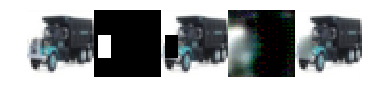

epoch: 0, g_loss: 0.9108, val_loss: 0.0162, d_loss: 15.0912, fake_err: 8.4875, real_err: 21.6948, time: 484.22


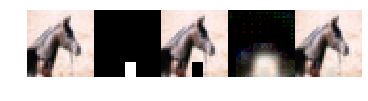

epoch: 1, g_loss: 0.9211, val_loss: 0.0163, d_loss: 14.8737, fake_err: 9.2564, real_err: 20.4910, time: 488.08


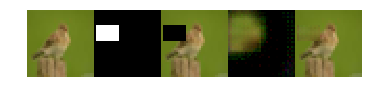

epoch: 2, g_loss: 0.9089, val_loss: 0.0169, d_loss: 14.7074, fake_err: 9.9802, real_err: 19.4347, time: 487.90


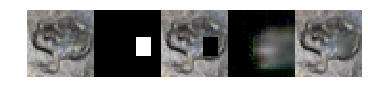

epoch: 3, g_loss: 0.8962, val_loss: 0.0154, d_loss: 14.5804, fake_err: 10.6465, real_err: 18.5144, time: 488.81


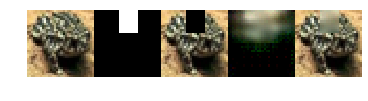

epoch: 4, g_loss: 0.9022, val_loss: 0.0181, d_loss: 14.4901, fake_err: 11.2533, real_err: 17.7269, time: 488.71


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


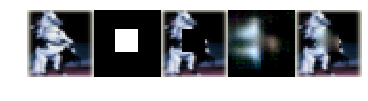

epoch: 5, g_loss: 0.8846, val_loss: 0.0164, d_loss: 14.4265, fake_err: 11.7915, real_err: 17.0615, time: 487.33


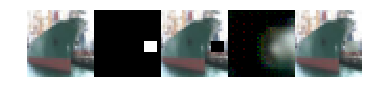

epoch: 6, g_loss: 0.8901, val_loss: 0.0166, d_loss: 14.3775, fake_err: 12.2545, real_err: 16.5004, time: 488.38


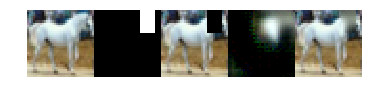

epoch: 7, g_loss: 0.8757, val_loss: 0.0154, d_loss: 14.3464, fake_err: 12.6550, real_err: 16.0377, time: 488.37


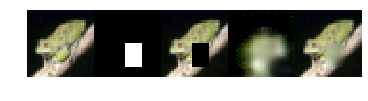

epoch: 8, g_loss: 0.8745, val_loss: 0.0149, d_loss: 14.3262, fake_err: 12.9923, real_err: 15.6601, time: 488.26


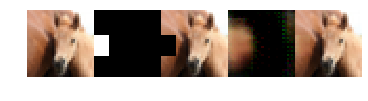

epoch: 9, g_loss: 0.8693, val_loss: 0.0156, d_loss: 14.3105, fake_err: 13.2682, real_err: 15.3529, time: 487.84


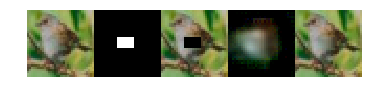

epoch: 10, g_loss: 0.8693, val_loss: 0.0161, d_loss: 14.3005, fake_err: 13.4931, real_err: 15.1079, time: 488.02


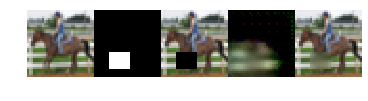

epoch: 11, g_loss: 0.8598, val_loss: 0.0154, d_loss: 14.2913, fake_err: 13.6723, real_err: 14.9104, time: 487.60


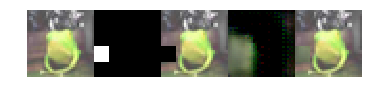

epoch: 12, g_loss: 0.8565, val_loss: 0.0155, d_loss: 14.2872, fake_err: 13.8176, real_err: 14.7568, time: 487.75


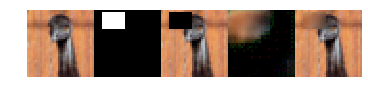

epoch: 13, g_loss: 0.8502, val_loss: 0.0150, d_loss: 14.2839, fake_err: 13.9306, real_err: 14.6372, time: 487.89


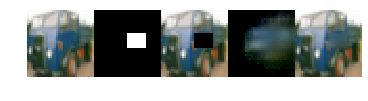

epoch: 14, g_loss: 0.8545, val_loss: 0.0146, d_loss: 14.2815, fake_err: 14.0188, real_err: 14.5442, time: 487.37


In [ ]:
train_params = {}
train_params['w'] = 0.0005
train_params['learning_rate_g'] = 0.0001
train_params['learning_rate_d'] = 0.00001
train_params['batch_size'] = 800
train_params['val_batch_size'] = 1024
train_params['T_c'] = 0
train_params['T_d'] = 0
train_params['epochs'] = 20 + train_params['T_c'] + train_params['T_d']

def gen_masks(N, ch=3):
    masks, bounds = create_hole_masks(N, 32, 32, (5, 12), (5, 12), same_size=False)
    return masks.repeat_interleave(ch, dim=1).cuda(), bounds

# optimizer_g = optim.Adam(generator.parameters(), lr=train_params['learning_rate_g'])
# optimizer_d = optim.Adam(discriminator.parameters(), lr=train_params['learning_rate_d'])

torch.cuda.empty_cache()
train_gan(generator, discriminator, train, val, optimizer_g, optimizer_d, train_params, gen_masks)

# Evaluation

In [ ]:
loss = 0
pixels = 0

In [ ]:
model = generator
model.eval()
N = 512
test_loader = iter(data.DataLoader(test, N, shuffle=True, pin_memory=False))

for batch, _ in test_loader:
    masks, _ = gen_masks(batch.shape[0])
    batch_masked = batch.clone().cuda() * (1 - masks)
    batch_masked = torch.cat((batch_masked, masks[:, :1]), dim=1)
    pred = model(batch_masked).clamp(0, 1).detach()

    loss += (((batch.cuda() - pred) * masks)**2).sum().detach().cpu()
    pixels += masks.sum().detach().cpu()
    
#     inpainted = batch.clone()
#     masks_byte = masks.byte()
#     inpainted[masks_byte] = pred[masks_byte].view(-1)
#     border = torch.zeros((3, 32, 2)) + 0.2196

print(loss / pixels)

# for i in range(batch.shape[0]):
#     imgs = [
#         batch[i].cpu(),
#         border,
#         batch_masked[:, :-1][i].cpu(), 
# #         pred[i].cpu(), 
#         border,
#         inpainted[i].cpu()
#     ]
#     tmp = torch.cat(imgs, dim=2)
#     imshow(tmp)
#     plt.axis('off')
#     plt.show()

tensor(0.0155)


# Model saving

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model_save_name = 'generator.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(generator.state_dict(), path)

model_save_name = 'discriminator.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(discriminator.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
